In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import sys
sys.path.append('../')

from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, GridSearchCV

from bikesharing.ml_logic.model import get_folds, train_test_indices
from bikesharing.interface.main import *
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error

In [4]:
df_X = pd.read_csv('~/.lewagon/bikesharing/data/processed/X_processed_from_2019_to_2022.csv')
df_y = pd.read_csv('~/.lewagon/bikesharing/data/processed/y_processed_from_2019_to_2022.csv')

In [7]:
df_X_y = pd.concat((df_X, df_y) , axis=1)
df_X_y.columns

Index(['temperature_2m', 'relativehumidity_2m', 'apparent_temperature',
       'windspeed_10m', 'precipitation', 'hour_sin', 'hour_cos', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'is_holiday', 'is_weekend',
       'Altstadt-Lehel', 'Au - Haidhausen', 'Aubing-Lochhausen-Langwied',
       'Berg am Laim', 'Bogenhausen', 'Feldmoching', 'Hadern', 'Harlaching',
       'Hasenbergl-Lerchenau Ost', 'Laim', 'Lochhausen',
       'Ludwigsvorstadt-Isarvorstadt', 'Maxvorstadt', 'Milbertshofen-Am Hart',
       'Moosach', 'Neuhausen-Nymphenburg', 'Obergiesing', 'Obermenzing',
       'Obersendling', 'Pasing', 'Pasing-Obermenzing', 'Ramersdorf-Perlach',
       'Schwabing-Freimann', 'Schwabing-West', 'Schwanthalerhöhe', 'Sendling',
       'Sendling-Westpark', 'Südgiesing', 'Thalkirchen', 'Trudering',
       'Trudering-Riem', 'Untergiesing', 'Untergiesing-Harlaching',
       'Untermenzing-Allach'],
      dtype='object')

In [8]:
fold_dfs = get_folds(df_X_y, fold_length=FOLD_LENGTH, fold_stride=FOLD_STRIDE)

In [10]:
districts = ['Altstadt-Lehel', 'Au - Haidhausen',
       'Aubing-Lochhausen-Langwied', 'Berg am Laim', 'Bogenhausen',
       'Feldmoching', 'Hadern', 'Harlaching', 'Hasenbergl-Lerchenau Ost',
       'Laim', 'Lochhausen', 'Ludwigsvorstadt-Isarvorstadt', 'Maxvorstadt',
       'Milbertshofen-Am Hart', 'Moosach', 'Neuhausen-Nymphenburg',
       'Obergiesing', 'Obermenzing', 'Obersendling', 'Pasing',
       'Pasing-Obermenzing', 'Ramersdorf-Perlach', 'Schwabing-Freimann',
       'Schwabing-West', 'Schwanthalerhöhe', 'Sendling', 'Sendling-Westpark',
       'Südgiesing', 'Thalkirchen', 'Trudering', 'Trudering-Riem',
       'Untergiesing', 'Untergiesing-Harlaching', 'Untermenzing-Allach']

## Feldmoching

In [45]:
district_score_means = []
district = 'Feldmoching'

test_df = fold_dfs[0]
train_folds = fold_dfs[1:]

train_df = pd.concat(train_folds, axis=0)
X_test = test_df.drop(columns=districts)
y_test = test_df[district]
X_train = train_df.drop(columns=districts)
y_train = train_df[district]

param_grid = {
    'n_estimators': [10, 30, 50, 70, 100],
    'max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror'),
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_estimator = grid_search.best_estimator_
print('best_estimator:', best_estimator)

y_pred_unchanged = best_estimator.predict(X_test)
y_pred = [x if x >= 0 else 0 for x in best_estimator.predict(X_test)]
r2 = r2_score(y_test, y_pred)
mse_score = np.sqrt(mean_squared_error(y_test, y_pred))
msle_score = np.sqrt(mean_squared_log_error(y_test, y_pred))

district_score_means.append((district, r2, mse_score, msle_score))
df_scores = pd.DataFrame(district_score_means, columns=['District', 'R2 Score', 'MSE Score', 'MSLE Score'])
print(df_scores)

best_estimator: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
      District  R2 Score  MSE Score  MSLE Score
0  Feldmoching  0.504937   0.268578    0.163947


In [35]:
model_filename = '../raw_data/models/feldmoching_xgb_model.pkl'
joblib.dump(best_estimator, model_filename)

['../raw_data/models/feldmoching_xgb_model.pkl']

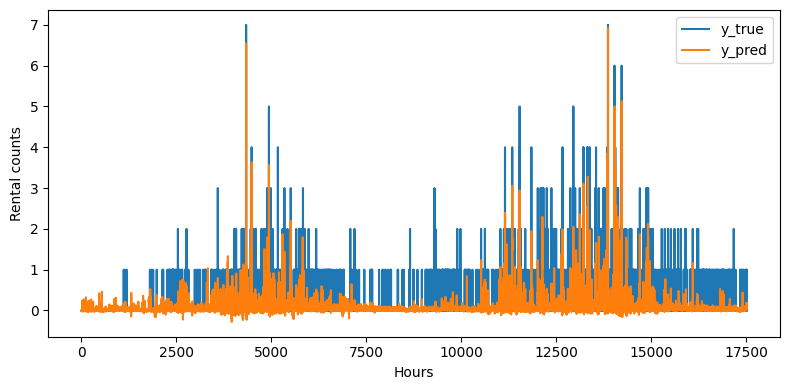

In [46]:
fig, ax = plt.subplots(figsize=(8, 4))

# Set a common x-axis
x = range(len(y_test))

# Plot y_true and y_pred
ax.plot(x, y_test, label='y_true')
ax.plot(x, y_pred_unchanged, label='y_pred')
ax.set_ylabel('Rental counts')
ax.set_xlabel('Hours')
ax.legend()

plt.tight_layout()
plt.show()

## Sendling

In [47]:
district_score_means = []
district = 'Sendling'

test_df = fold_dfs[0]
train_folds = fold_dfs[1:]

train_df = pd.concat(train_folds, axis=0)
X_test = test_df.drop(columns=districts)
y_test = test_df[district]
X_train = train_df.drop(columns=districts)
y_train = train_df[district]

param_grid = {
    'n_estimators': [10, 30, 50, 70, 100],
    'max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror'),
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_estimator = grid_search.best_estimator_
print('best_estimator:', best_estimator)

y_pred_unchanged = best_estimator.predict(X_test)
y_pred = [x if x >= 0 else 0 for x in best_estimator.predict(X_test)]
r2 = r2_score(y_test, y_pred)
mse_score = np.sqrt(mean_squared_error(y_test, y_pred))
msle_score = np.sqrt(mean_squared_log_error(y_test, y_pred))

district_score_means.append((district, r2, mse_score, msle_score))
df_scores = pd.DataFrame(district_score_means, columns=['District', 'R2 Score', 'RMSE Score', 'RMSLE Score'])
print(df_scores)

best_estimator: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
   District  R2 Score  MSE Score  MSLE Score
0  Sendling  0.706881   2.102252    0.537125


In [48]:
model_filename = '../raw_data/models/sendling_xgb_model.pkl'
joblib.dump(best_estimator, model_filename)

['../raw_data/models/sendling_xgb_model.pkl']

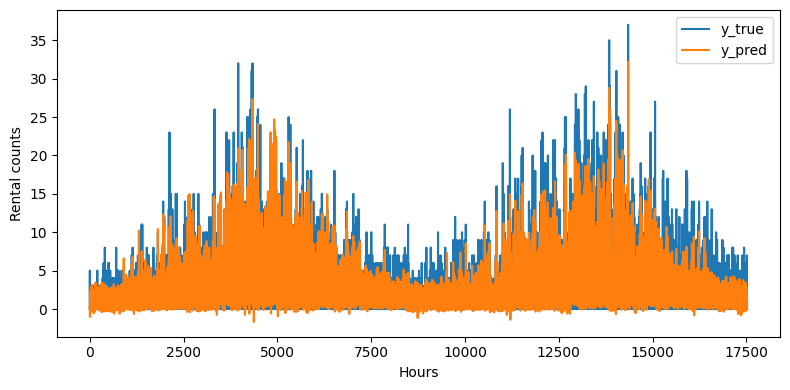

In [49]:
fig, ax = plt.subplots(figsize=(8, 4))

# Set a common x-axis
x = range(len(y_test))

# Plot y_true and y_pred
ax.plot(x, y_test, label='y_true')
ax.plot(x, y_pred_unchanged, label='y_pred')
ax.set_ylabel('Rental counts')
ax.set_xlabel('Hours')
ax.legend()

plt.tight_layout()
plt.show()